# La vitrine de QQDN

## Les imports

In [15]:

#pour colab, sinon changer le chemin "/content" ou supprimer ce test
import os
if os.path.exists("/content"):
    !git init
    !git pull https://github.com/vincentvigon/RECHERCHE.git
    %ls
else:
    print("on n'est pas sur colab")

import popup_lib.popup as pop

Reinitialized existing Git repository in /content/.git/
From https://github.com/vincentvigon/RECHERCHE
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
 ddqn_lib/   Euler/  'Icon'$'\r'   popup_lib/   sample_data/   toto.py*


In [16]:
%ls

 ddqn_lib/   Euler/  'Icon'$'\r'   popup_lib/   sample_data/   toto.py*


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from typing import *
import tensorflow as tf
import time

In [18]:
import ddqn_lib.ddqn as dd

## Un exemple 1D

### L'environnement bille 1D

Une bille doit rester dans un intervalle. Elle est soumise à un vent aléatoire,
que le controle doit compenser.

La difficulté pour l'agent, c'est qu'il ne sait qu'il a perdu que lorsque
la bille sort de l'intervalle. Il doit donc comprendre que les positions
au centre de l'intervalles sont les meilleurs.

In [19]:
class Toy_Env(dd.Abstract_Environment):
    def get_dim_state(self) -> int:
        return 1

    def get_dim_action(self) -> int:
        return 1

    def __init__(self,sigma=1):
        self.value=0
        self.count = 0
        self.sigma=sigma

    def reset(self)->np.ndarray:
        self.value=np.random.uniform(-10,10)
        self.count = 0
        return np.array([self.value])

    def step(self, action):
        self.value+= action + self.sigma * np.random.normal()
        self.count+=1

        terminal_bad = False
        terminal_good = False

        inside = -20 <= self.value <= +20
        if not inside:
            terminal_bad = True

        if terminal_bad:
            reward = -10
        else:
            reward = 1

        # on gagne si la bille reste 100 fois
        if self.count > 100:
            terminal_good = True
            reward = 50

        terminal = terminal_bad or terminal_good
        if terminal:
            self.reset()  # la position est réinitialiser

        return np.array([self.value]), reward, terminal

### Les réseaux de neurones

In [20]:
def actor_maker_fn():
    input_state=tf.keras.layers.Input([1])
    y=tf.keras.layers.Dense(4,activation="relu")(input_state)
    output_action=tf.keras.layers.Dense(1)(y)
    return tf.keras.Model(inputs=input_state,outputs=output_action)

def critic_maker_fn():
    input_state = tf.keras.layers.Input([1])
    input_action = tf.keras.layers.Input([1])
    y_state = tf.keras.layers.Dense(3,activation="relu")(input_state)
    y_action = tf.keras.layers.Dense(3,activation="relu")(input_action)
    y=tf.keras.layers.Concatenate()([y_state,y_action])
    y=tf.keras.layers.Dense(3,activation="relu")(y)
    output_critic = tf.keras.layers.Dense(1)(y)
    return tf.keras.Model(inputs=[input_state,input_action], outputs=output_critic)

### Entrainement solo

On voit que l'entrainement d'un agent ddqn est très instable (faites différent run pour le constater).
Parfois on réussit très vite (on atteint un score de 150), parfois cela échoue complètement.

In [21]:
def perturm_famparams(famparams):
    pass

agent=dd.Agent_ddqn(Toy_Env(),actor_maker_fn,critic_maker_fn,perturm_famparams)
scores=[]
ite=-1
print("scores")
weights=None
for _ in range(20):
    ite+=1
    score=agent.optimize_return_score()
    print(f"|{score:.1f}",end="")
    scores.append(score)
    if score>=np.max(scores):
        print("_record",end="")
        weights=agent.get_copy_of_weights()
fig,ax=plt.subplots()
ax.set_title("score train")
ax.plot(scores)

TypeError: ignored

### Validation

In [ ]:
print("validation:")
agent.set_weights(weights)
print("scores validation:")
for _ in range(10):
    ite+=1
    score=agent.return_score()
    print(f"|{score:.1f}",end="")
    scores.append(score)

fig, ax = plt.subplots()
ax.set_title("score val")
ax.plot(scores)
plt.show()

validation:


TypeError: 'NoneType' object is not subscriptable

### Entrainement en famille

Comme l'exemple est très simple, on ne perturbe même pas les famparams.
On se contente de lancer plusieur agents (donc avec des poids initiaux différents).

Les mutations permettent ensuite de supprimer les agents qui sont mal engagés.

In [ ]:
def perturb_famparams(famparams):
    famparams["lr"]*=np.random.uniform(0.7,1.7)
    famparams["perturb_action_sigma"]*=np.random.uniform(0.7,1.7)
    gamma=np.clip(famparams["gamma"]*np.random.uniform(0.9,1.1),0.5,0.999)
    famparams["gamma"]=gamma

agents=[dd.Agent_ddqn(Toy_Env(),actor_maker_fn,critic_maker_fn,perturb_famparams,perturb_action_sigma=1e-3) for _ in range(5)]
family_trainer=pop.Family_trainer(
    agents,
    "2 seconds",
    perturb_famparams
    )

TypeError: __init__() missing 1 required positional argument: 'perturb_famparams'

In [ ]:
for _ in range(5):
    family_trainer.period()

NameError: name 'family_trainer' is not defined

In [ ]:
family_trainer.plot_metric("score")

NameError: name 'family_trainer' is not defined

## Un exemple en grande dimension

### L'environnement

In [22]:
DIM=300
SIGMA_NOISE=3
DRIFT=1e-1

def random_sinus_sum(dim):
    res=np.zeros([dim])
    x=np.linspace(0,2*np.pi,dim)
    for i in range(1,10):
        res+=np.random.uniform(-0.2,0.2)*np.sin(i*x)
    return res


In [23]:
"""Il faut bien régler les paramètres sigma et initial_size
 pour que l'on ne gagne pas à chaque coup: utiliser le test_zero_action() pour vérifier """
class Sinus_Env(dd.Abstract_Environment):

    def __init__(self, dim=DIM, sigma_noise=SIGMA_NOISE, initial_size=5, reward_when_win=100):
        self.dim=dim
        self.sigma_noise = sigma_noise
        self.initial_size=initial_size
        self.reward_when_win=reward_when_win
        self.value=np.zeros([dim])
        self.count = 0
        self.render_is_active=False

    def get_dim_state(self) -> int:
        return self.dim

    def get_dim_action(self) -> int:
        return self.dim

    def reset(self)->np.ndarray:
        self.value= random_sinus_sum(self.dim)*self.initial_size
        self.count=0
        return self.value

    def step(self, action):
        assert action.shape==(self.dim,), f"action must have the dimension {self.dim} but shape is {action.shape} "
        self.value+= action + self.sigma_noise * random_sinus_sum(self.dim)+DRIFT
        self.count+=1

        terminal_bad = False
        terminal_good = False

        too_big=np.sum(self.value>20)
        too_small=np.sum(self.value<-20)
        inside = too_big+too_small ==0
        if not inside:
            terminal_bad = True

        if terminal_bad:
            reward = -self.reward_when_win
        else:
            reward = 1

        # on gagne si la fonction reste 100 fois dans les bornes
        if self.count > 100:
            terminal_good = True
            reward = self.reward_when_win

        terminal = terminal_bad or terminal_good
        if terminal:
            self.reset()  # la position est réinitialiser
        if self.render_is_active:
            self._record_for_render()

        return self.value, reward, terminal


    def start_render(self):
        self.render_is_active=True
        self.curves=[]
        self.current_render_stop=0

    def do_render(self):
        x=np.linspace(0,2*np.pi,self.dim)
        self.render_is_active=False
        nb=len(self.curves)
        for i,curve in enumerate(self.curves):
            if i==0:
                alpha=1
                color="r"
            else:
                alpha = i / nb
                color="k"
            plt.plot(x,curve,color,alpha=alpha)
        plt.show()

    def _record_for_render(self):
        self.curves.append(self.value.copy())

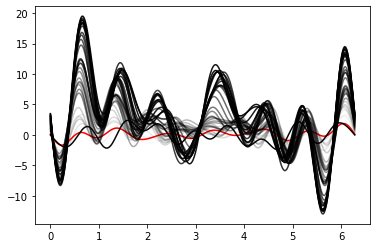

reward:-100, count:36


In [24]:
def test_env_graph():
    dim=300
    env=Sinus_Env(dim)
    zero_action=np.zeros([dim])
    done=False
    env.start_render()
    r=0
    count=0
    while not done:
        count+=1
        s_,r,done=env.step(zero_action)
    env.do_render()
    print(f"reward:{r}, count:{count}")
    
test_env_graph()

### Une baseline: la politique constante

In [25]:
def evaluate_policy(env:Sinus_Env, policy):
    rewards=[]
    ep_lengths=[]
    nb_win=0
    nb_test=40
    for _ in range(nb_test):
        r = None
        ep_length = 0
        cum_reward=0
        done=False
        s=env.reset()
        while not done:
            ep_length+=1
            s,r,done=env.step(policy(s))
            cum_reward+=r
        if r==env.reward_when_win:
            nb_win+=1
        ep_lengths.append(ep_length)
        rewards.append(cum_reward)

    print(f"win:{nb_win/nb_test} cum_rewards:{np.mean(rewards)}, episode length:{np.mean(ep_lengths)}")

def test_constant_policy():
    env=Sinus_Env(DIM)
    policy=lambda state:np.zeros([env.dim])-DRIFT
    evaluate_policy(env, policy)
test_constant_policy()


win:0.825 cum_rewards:162.4, episode length:98.4


### Les modèles

In [26]:
def layer_triple(y):
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    return y

def actor_maker_fn():
    input_state=tf.keras.layers.Input([DIM,1])
    y=layer_triple(input_state)
    output_action=tf.keras.layers.Conv1D(1,5,padding="same")(y)
    #il faut une action de taille comparable au bruit pour pouvoir le compenser
    output_action=output_action[:,:,0]*SIGMA_NOISE
    return tf.keras.Model(inputs=input_state,outputs=output_action)

def critic_maker_fn():
    input_state = tf.keras.layers.Input([DIM,1])
    input_action = tf.keras.layers.Input([DIM,1])
    y_state = layer_triple(input_state)
    y_action = layer_triple(input_action)
    y=tf.keras.layers.Concatenate()([y_state,y_action])
    y=layer_triple(y)
    output_critic = tf.keras.layers.Conv1D(1,5,padding="same")(y)
    output_critic = output_critic[:,:,0]
    return tf.keras.Model(inputs=[input_state,input_action], outputs=output_critic)

def test_models():
    batch_size=3
    input_action=np.random.normal(size=[batch_size,DIM,1])
    input_critic = np.random.normal(size=[batch_size,DIM,1])
    model_actor=actor_maker_fn()
    model_critic=critic_maker_fn()
    res_actor=model_actor(input_action).numpy()
    print(f"actor result shape{res_actor.shape} , sdt:{np.std(res_actor.flatten())}")
    res_critic=model_critic([input_action,input_critic]).numpy()
    print(f"actor result shape{res_critic.shape} , sdt:{np.std(res_critic.flatten())}")

test_models()

actor result shape(3, 300) , sdt:0.5635216236114502
actor result shape(3, 300) , sdt:0.09346386790275574


### Entrainement d'un seul agent

In [ ]:
def main_one():
    env=Sinus_Env()
    print("The constant policy gives:")
    evaluate_policy(env, lambda state: np.zeros([env.dim])-DRIFT)

    agent=dd.Agent_ddqn(env,actor_maker_fn,critic_maker_fn,
                     perturb_action_sigma=1e-2,
                     min_seconds_before_score=3)
    scores=[]
    ite=-1
    minutes=3
    ti0=time.time()
    print("scores")
    try:
        while time.time()-ti0<minutes*60:
            ite+=1
            score=agent.optimize_return_score()
            print(f"|{score:.0f}",end="")
            scores.append(score)
            if score >= np.max(scores):
                print("_record", end="")
    except KeyboardInterrupt:
        print("\ninteruption")

    plt.show()
    
main_one()

The zero policy gives:
win:0.0 cum_rewards:-32.05, episode length:68.95
scores
|-90_record|-82_record|7_record|-26|54_record|-12|3|-16|33|-11|-6|-52|37|-16|-34|55_record|-46|-17|-46|8|-13|41|300_record|-17|14|83

### Entrainement d'une famille

In [27]:
def main_train_family_sin():
    env = Sinus_Env()
    print("The constant policy gives:")
    evaluate_policy(env, lambda state: np.zeros([env.dim]))


    def perturb_famparams(agent):
        agent.famparams["lr"]*=np.random.uniform(0.7,1.7)
        agent.famparams["perturb_action_sigma"]*=np.random.uniform(0.7,1.7)
        gamma=np.clip(agent.famparams["gamma"]*np.random.uniform(0.9,1.1),0.5,0.999)
        agent.famparams["gamma"]=gamma

    dd.Agent_ddqn.perturb_famparams=perturb_famparams

    agents = [dd.Agent_ddqn(env, actor_maker_fn, critic_maker_fn,
                          lr=10**np.random.uniform(-3,-1),
                          perturb_action_sigma=10**np.random.uniform(-3,-1),
                          min_seconds_before_score=3)
              for _ in range(5)]

    def do_something_at_period_begin():
        env.reset()

    family_trainer=pop.Family_trainer(agents,
                                      period_for_each="5 seconds",
                                      nb_bestweights_averaged=1,

    for _ in range(10):
        family_trainer.period()

    return family_trainer

SyntaxError: ignored

In [ ]:
family_trainer=main_train_family_sin()

The constant policy gives:
win:0.0 cum_rewards:-36.7, episode length:64.3

 fam_8, period_count:0, each agent turns 5.0 seconds:|a↗-74.0___|b↗-98.2↗-97.4444↗-86.0↗-74.5|c↗-90.3333↗-83.6667↗-65.0|d↗-86.0__↗-66.0|e↗-98.3↗-98.0909↗-90.3333_, mutations:e⇇c|b⇇d|
 fam_8, period_count:1, each agent turns 5.0 seconds:|a_↗-68.0↗-49.0|b____|c____|d___|e↗-67.0↗-22.0_, mutations:b⇇d⇇e|d⇇a|
 fam_8, period_count:2, each agent turns 5.0 seconds:|a___|b↗-41.0__|c_↗-57.0↗-8.0|d↗-64.0↗-63.0↗-48.0|e___, mutations:a⇇c|d⇇a⇇e|
 fam_8, period_count:3, each agent turns 5.0 seconds:|a↗-33.0_↗-23.0|b__↗-40.0|c__|d↗-24.0_|e_↗-14.0_, mutations:b⇇d⇇e⇇c|d⇇a⇇e⇇e|
 fam_8, period_count:4, each agent turns 5.0 seconds:|a___|b↗-26.0↗-23.0_|c___|d__|e__, mutations:d⇇a⇇e⇇e⇇c|a⇇c⇇e|
 fam_8, period_count:5, each agent turns 5.0 seconds:|a___|b___|c___|d↗-4.0_|e___, mutations:a⇇c⇇e⇇d|b⇇d⇇e⇇c⇇c|
 fam_8, period_count:6, each agent turns 5.0 seconds:|a__|b___|c___|d__|e__, mutations:a⇇c⇇e⇇d⇇d|b⇇d⇇e⇇c⇇c⇇c|
 fam_8, period_count:7

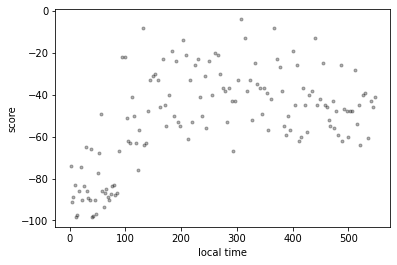

In [ ]:
family_trainer.plot_metric("score")

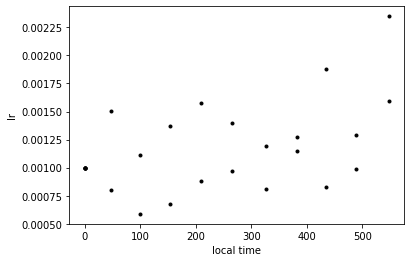

In [ ]:
family_trainer.plot_metric("lr")

### Analysons le meilleurs agent

In [ ]:
best_agent=family_trainer.get_best_agent()

In [ ]:
sinus_env=Sinus_Env()

In [ ]:
evaluate_policy(sinus_env,lambda state:best_agent.policy(state,val_mode=True))

win:0.0 cum_rewards:-47.45, episode length:53.55


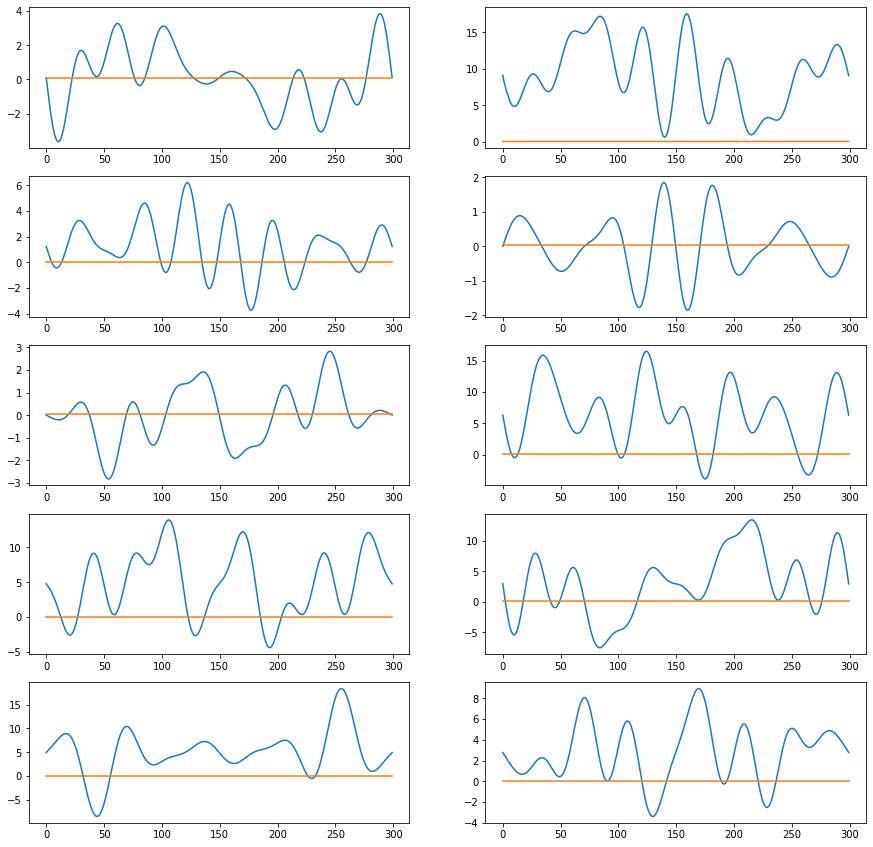

In [ ]:
states=[]
action=np.zeros(DIM)
actions=[]
for i in range(1000):
    state,_,_=sinus_env.step(action)
    action=best_agent.policy(state,True)
    if i%100==0:
        states.append(state)
        actions.append(action)

fig,axs=plt.subplots(5,2,figsize=(15,15))
axs=axs.flatten()
x=range(DIM)
for i,ax in enumerate(axs):
    ax.plot(x,states[i])
    ax.plot(x,actions[i])

Si le `DRIFT` est positif, il faudrait que l'action en moyenne soit négative: 

In [ ]:
np.mean(actions),DRIFT

(0.054029144, 0.1)